# TWO WAY DESIGN (2WD) AND HIGHER LEVEL DESIGNS

This lecture continues the analysis of the Wolf model of glycolytic oscillations to consider the effects of two parameters in combination.

A two way design (2WD) is used to identify interactions between factors.
This means that there is an experiment for every combination of levels of both factors.
That is, there are $n_1 \times n_2$ experiments if there are $n_i$ levels of the two factors.

## Challenges

1. **Combinatorics.**
The Wolf model has 16 parameters, which means that there are 120 interactions, each of which need to be calculated at several levels.
With 10 levels for each interaction, this results in $10 \times 10 \times 120 = 12,000$ constants to calculate.
1. **Visualization.**
How should we present the responses that clearly presents which interaction terms are displayed, their values, and patterns in the responses?
1. **Generalizing 1WD codes for 2WD**. ``runExperiments`` and other codes assumed a 1-way interaction.

# Review

## Why design of experiments (DOE)?

## Governing formulas

$y_{i, k_i, j, k_j}$ - response changing factors $i$ and $j$ to levels $k_i$ and $k_j$, respectively.

1. 0WD: $y - \mu$, where $\mu$ is the response when there is no change.
1. 1WD: $y_{i, k_i} = \mu + \alpha_{i, k_i}$
1. 2WD: $y_{i, k_i, j, k_j} = \mu + \alpha_{i, k_i} + \alpha_{j, k_j} + \beta_{i, k_i, j, k_j}$
1. 3WD: $y_{i, k_i, j, k_j, n, k_n} = \mu + \alpha_{i, k_i} + \alpha_{j, k_j} + \alpha_{n, k_n} + \beta_{i, k_i, j}
+ \beta_{i, k_i, n, k_n} + \beta_{j, k_j, n, k_n}
+  \gamma_{i, k_i, j, k_j, n, k_n}$

# Preliminaries

## Imports

In [1]:
try:
    import tellurium as te
except:
    !pip install -q tellurium==2.2.0
    import tellurium as te

#import util_doe1 as doe1

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import fftpack
import seaborn as sns
#import util_doe1  # Various functions from lecture 5

## Wolf Model

In [2]:
'''Codes and Constants for the Wolf Model'''


################## CONSTANTS #############################
WOLF_MODEL = """
// Created by libAntimony v2.12.0
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;

  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k, J4_kg;
  const J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2, J9_k, J10_k;
end
"""
WOLF_RR = te.loada(WOLF_MODEL)
START = 0
END = 5
NUMPT = 300  # number of points to simulate
WOLF_DATA = WOLF_RR.simulate(START, END, NUMPT)
WOLF_PRMS = [
  "J0_inputFlux", "J1_k1", "J1_Ki", "J1_n", "J2_k", "J3_k", "J4_kg", "J4_kp",
 "J4_ka", "J4_kk", "J5_k", "J6_k", "J7_k", "J8_k1", "J8_k2", "J9_k", "J10_k",     
]
# Floating species in the Wolf model
WOLF_MOL = ["Glucose", "fructose_1_6_bisphosphate", "glyceraldehyde_3_phosphate",
     "glycerate_3_phosphate", "pyruvate", "Acetyladehyde", "External_acetaldehyde",
     "ATP", "ADP", "NAD", "NADH"]


## DOE Codes

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import fftpack
import tellurium as te
import seaborn as sns


################## CONSTANTS #############################
AMPLIDX = 1  # Index of amplitude values
FONTSIZE = 16
FREQIDX = 0  # Index of frequency values
TIME = "time"
SMALLEST_PCT = -100  # Smallest percent change in a parameter value
TIME_OFFSET = 150


###################### FUNCTIONS #####################
def arrToDF(arr, isSimulation=True):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    if isSimulation:
        df = df.set_index(TIME)
    return df

def runSimulation(parameterDct, roadrunner=None, model=WOLF_MODEL,
      startTime=START, endTime=END, numPoint=NUMPT):
    """
    Runs a simulation for parameters with percentage changes from baseline values.

    Parameters
    ----------
    parameterDct: dict
       key: parameter
       value: float
           percent change
    roadrunner: ExtendedRoadRunner
    startTime: float
    endTime: float
    numPoint: int
       
    Returns
    -------
    NamedArray: results of simulation
    """
    if roadrunner is None:
        roadrunner = te.loada(model)
    else:
        roadrunner.resetAll()
    for parameter, percent in parameterDct.items():
        baseValue = roadrunner[parameter]
        roadrunner[parameter] = baseValue*(1 + 0.01*percent)
    # Run the simulation
    data = roadrunner.simulate(startTime, endTime, numPoint)
    return arrToDF(data)

def plotOverTime(df, title="", figsize=(8, 4), isPlot=True):
    """
    Plots a simulation dataframe

    Parameters
    ----------
    df: DataFrame (SimulationOutput format)
    title: str
    figsize: (float, float)
        size of figure
    isPlot: bool
        Show the plot
    """
    fig, ax = plt.subplots(1, figsize=figsize)
    arr = df.values
    p = ax.plot(df.index, arr)
    _ = ax.legend(p, df.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
    _ = ax.set_title(title)
    if isPlot:
        plt.show()

def calcFFTPeak(molecule, df, **kwargs):
    """
    Obtains the highest amplitude frequency and value for the molecule.
    
    Parameters
    ----------
    molecule: str
    df: DataFrame
    kwargs: dict
        arguments passed to calcFFT
    
    Returns
    -------
    frequency: float
    amplitude: float
    """
    frequencies, amplitudes = calcFFT(molecule, df, **kwargs)
    # Find the indices of the largest amplitudes
    sortedIndices = sorted(range(len(frequencies)),
          key=lambda i: amplitudes[i], reverse=True)
    topIdx = sortedIndices[0]
    return frequencies[topIdx], amplitudes[topIdx]

def calcFFT(molecule, df, offset=TIME_OFFSET):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    df: DataFrame
    offset: int
        Initial data that are not included in the FFT calculation
        
    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    # Returns frequencies and abs(fft) for a chemical species (molecule)
    col = molecule
    values = df[col].values
    numPoint = len(df)
    count = numPoint - offset
    endTime = max(df.index)
    startTime= min(df.index)
    span = (endTime - startTime)/numPoint
    freqs = fftpack.fftfreq(count, span)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    return freqs[1:], fftValues[1:]

def runFFTExperiment(parameterDct, **kwargs):
    """
    Runs an experiment by changing parameters by the specified
    fractions and calculating FFT peak frequencies and amplitudes.
    
    Parameters
    ----------
    parameterDct: dict
       key: parameter name
       value: percent change the parameter
    kwargs: dict
       keyword arguments passed to runSimulation
       
    Returns
    -------
    frequencySer: pd.Series
        index: molecule
        value: frequency with largest amplitude
    amplitudeSer: pd.Series
        index: molecule
        value: largest amplitude
    """
    df = runSimulation(parameterDct, **kwargs)
    frequencyDct = {}
    amplitudeDct = {}
    for molecule in df.columns:
        frequency, amplitude = calcFFTPeak(molecule, df)
        frequencyDct[molecule] = frequency
        amplitudeDct[molecule] = amplitude
    return pd.Series(frequencyDct), pd.Series(amplitudeDct)

## Constants

In [4]:
WOLF_FACTORS = [
  "J0_inputFlux", "J1_k1", "J1_Ki", "J1_n", "J2_k", "J3_k", "J4_kg", "J4_kp",
 "J4_ka", "J4_kk", "J5_k", "J6_k", "J7_k", "J8_k1", "J8_k2", "J9_k", "J10_k",     
]

# Generalize runExperiments
Generalize ``runExperiments`` so that it calculates responses for all combinations of levels of two factors.

In [5]:
WOLF_PRMS

['J0_inputFlux',
 'J1_k1',
 'J1_Ki',
 'J1_n',
 'J2_k',
 'J3_k',
 'J4_kg',
 'J4_kp',
 'J4_ka',
 'J4_kk',
 'J5_k',
 'J6_k',
 'J7_k',
 'J8_k1',
 'J8_k2',
 'J9_k',
 'J10_k']

In [6]:
def runExperiments2WD(factor1, factor2, percent1s, percent2s, isRelative=True):
    """
    Runs experiments for multiple factors at different percent changes in factor levels.
    
    Parameter
    ---------
    factor1: str
    factor2: str
    percent1s: list-int
    percent2s: list-int
    isRelative: bool
        True: values are percent changes relative to baseline
        False: absolute value
        
    Returns
    -------
    frequencyDF: DataFrame; amplitude: DataFrame
       index: tuple of percent changes in factor values
       columns: molecule
       value: depends on isRelative
       index.name: string of tuple (rowFactor, columnFactor)
    """
    # Constants
    INDEX1 = "index1"
    INDEX2 = "index2"
    def appendSer(ser, baseSer, sers):
        adjSer = 100*(ser - baseSer) / baseSer
        sers.append(pd.DataFrame(adjSer).transpose())
    def calcResult(sers):
        resultDF = pd.concat(sers)
        resultDF[INDEX1] = index1
        resultDF[INDEX2] = index2
        resultDF = resultDF.set_index([index1, index2])
        for column in [INDEX1, INDEX2]:
            del resultDF[column]
        resultDF.index.name = str((factor1, factor2))
        return resultDF
    # Initializations
    index1 = []
    index2 = []
    frequencySers = []  # Collection of experiment results
    amplitudeSers = []
    baseFrequencySer, baseAmplitudeSer = runFFTExperiment({})
    # Calculate the changes
    for percent1 in percent1s:
        for percent2 in percent2s:
            #indices.append("%d_%d" % (percent1, percent2))
            index1.append(percent1)
            index2.append(percent2)
            factorDct = {factor1: percent1, factor2: percent2}
            frequencySer, amplitudeSer = runFFTExperiment(factorDct)
            appendSer(frequencySer, baseFrequencySer, frequencySers)
            appendSer(amplitudeSer, baseAmplitudeSer, amplitudeSers)
    # Construct the result dataframe
    frequencyDF = calcResult(frequencySers)
    amplitudeDF = calcResult(amplitudeSers)
    return frequencyDF, amplitudeDF

# Tests
percents = [-7, -5, -2, 0, 2, 5, 7]
fDF, aDF = runExperiments2WD("J1_Ki", "J1_k1", percents, percents)
assert(aDF.loc[(percents[-1], percents[-1]), "Glucose"] < 0 )
assert(fDF.loc[(percents[0], percents[0]), "Glucose"] < 0 )

Exercise: Run 2 way experiments changing ``J1_n``,
 ``J2_k``, for ``[-2, 0, 2]`` and tell me the change in pyruvate for $y_{1,k_1,2,k_3}$

In [7]:
# Solution
percents = [-20, -10, -2, 0, 2, 10, 20]
fDF, aDF = runExperiments2WD("J1_n", "J2_k", percents, percents)
fDF

Glucose  fructose_1_6_bisphosphate  ...        NAD       NADH
-20 -20 -92.307692                 -92.307692  ... -92.307692 -92.307692
    -10 -92.307692                 -92.307692  ... -92.307692 -92.307692
    -2  -92.307692                 -92.307692  ... -92.307692 -92.307692
     0  -92.307692                 -92.307692  ... -92.307692 -92.307692
     2  -92.307692                 -92.307692  ... -92.307692 -92.307692
     10 -92.307692                 -92.307692  ... -92.307692 -92.307692
     20 -92.307692                 -92.307692  ... -92.307692 -92.307692
-10 -20 -92.307692                 -92.307692  ... -92.307692 -92.307692
    -10 -92.307692                 -92.307692  ... -92.307692 -92.307692
    -2  -92.307692                 -92.307692  ... -92.307692 -92.307692
     0  -92.307692                 -92.307692  ... -92.307692 -92.307692
     2  -92.307692                 -92.307692  ... -92.307692 -92.307692
     10 -92.307692                 -92.307692  ... -92.307692 -92.307692
     20 -92.307692                 -92.307692  ... -92.307692 -92.307692
-2  -20   0.000000                   0.000000  ...   0.000000   0.000000
    -10   0.000000                   0.000000  ...   0.000000   0.000000
    -2    0.000000                   0.000000  ...   0.000000   0.000000
     0    0.000000                   0.000000  ...   0.000000   0.000000
     2    0.000000                   0.000000  ...   0.000000   0.000000
     10   7.692308                   7.692308  ...   7.692308   7.692308
     20   7.692308                   7.692308  ...   7.692308   7.692308
 0  -20  -7.692308                  -7.692308  ...  -7.692308  -7.692308
    -10  -7.692308                  -7.692308  ...  -7.692308  -7.692308
    -2    0.000000                   0.000000  ...   0.000000   0.000000
     0    0.000000                   0.000000  ...   0.000000   0.000000
     2    0.000000                   0.000000  ...   0.000000   0.000000
     10   0.000000                   0.000000  ...   0.000000   0.000000
     20   0.000000                   0.000000  ...   0.000000   0.000000
 2  -20 -15.384615                 -15.384615  ... -15.384615 -15.384615
    -10  -7.692308                  -7.692308  ...  -7.692308  -7.692308
    -2   -7.692308                  -7.692308  ...  -7.692308  -7.692308
     0   -7.692308                  -7.692308  ...  -7.692308  -7.692308
     2   -7.692308                  -7.692308  ...  -7.692308  -7.692308
     10   0.000000                   0.000000  ...   0.000000   0.000000
     20   0.000000                   0.000000  ...   0.000000   0.000000
 10 -20 -30.769231                 -30.769231  ... -30.769231 -30.769231
    -10 -30.769231                 -30.769231  ... -30.769231 -30.769231
    -2  -23.076923                 -23.076923  ... -23.076923 -23.076923
     0  -23.076923                 -23.076923  ... -23.076923 -23.076923
     2  -23.076923                 -23.076923  ... -23.076923 -23.076923
     10 -23.076923                 -23.076923  ... -23.076923 -23.076923
     20 -15.384615                 -15.384615  ... -15.384615 -15.384615
 20 -20 -46.153846                 -46.153846  ... -46.153846 -46.153846
    -10 -46.153846                 -46.153846  ... -46.153846 -46.153846
    -2  -46.153846                 -46.153846  ... -46.153846 -46.153846
     0  -46.153846                 -46.153846  ... -46.153846 -46.153846
     2  -38.461538                 -38.461538  ... -38.461538 -38.461538
     10 -38.461538                 -38.461538  ... -38.461538 -38.461538
     20 -38.461538                 -38.461538  ... -38.461538 -38.461538

[49 rows x 11 columns]

Exercise: For Glucose (chemical species), calculate $\mu$, $\alpha$, $\beta$ for the two factors ``J1_n``,
 ``J2_k``, for ``[-2, 0, 2]``.

Hints:
1. Start by calculating $\mu$. (Where is $\mu$ in the table?)
1. $\alpha_{i,k_i} = y_{i, k_i} - \mu$
1. $\beta_{i, k_i, j, k_j} = y_{i, k_i, j, k_j} - \mu - 
\alpha_{i,k_i} - \alpha_{j,k_j}$

In [8]:
# Calculate mu, a scalar
mu = fDF.loc[(0, 0), "Glucose"]
mu

0.0

In [9]:
# Calculate the alphas
indices_1 = [i for i in fDF.index if i[1] == 0]
alpha1Ser = fDF.loc[indices_1, "Glucose"] - mu
alpha1Ser

-20  0   -92.307692
-10  0   -92.307692
-2   0     0.000000
 0   0     0.000000
 2   0    -7.692308
 10  0   -23.076923
 20  0   -46.153846
Name: Glucose, dtype: float64

In [10]:
# Calculate the alphas (second factor)
indices_2 = [i for i in fDF.index if i[0] == 0]
alpha2Ser = fDF.loc[indices_2, "Glucose"] - mu
alpha2Ser

0  -20   -7.692308
   -10   -7.692308
   -2     0.000000
    0     0.000000
    2     0.000000
    10    0.000000
    20    0.000000
Name: Glucose, dtype: float64

In [11]:
# Calculate the betas
betaSer = fDF.copy()["Glucose"] - mu
for level_1, level_2 in betaSer.index:
    betaSer.loc[(level_1, level_2)] = betaSer.loc[(level_1, level_2)] - alpha1Ser.loc[(level_1, 0)] \
    - alpha2Ser.loc[(0, level_2)]    

In [12]:
betaSer

-20  -20    7.692308e+00
     -10    7.692308e+00
     -2     0.000000e+00
      0     0.000000e+00
      2     0.000000e+00
      10    0.000000e+00
      20    0.000000e+00
-10  -20    7.692308e+00
     -10    7.692308e+00
     -2     0.000000e+00
      0     0.000000e+00
      2     0.000000e+00
      10    0.000000e+00
      20    0.000000e+00
-2   -20    7.692308e+00
     -10    7.692308e+00
     -2     0.000000e+00
      0     0.000000e+00
      2     0.000000e+00
      10    7.692308e+00
      20    7.692308e+00
 0   -20    0.000000e+00
     -10    0.000000e+00
     -2     0.000000e+00
      0     0.000000e+00
      2     0.000000e+00
      10    0.000000e+00
      20    0.000000e+00
 2   -20   -1.953993e-14
     -10    7.692308e+00
     -2     0.000000e+00
      0     0.000000e+00
      2     0.000000e+00
      10    7.692308e+00
      20    7.692308e+00
 10  -20   -5.329071e-15
     -10   -5.329071e-15
     -2     0.000000e+00
      0     0.000000e+00
      2     0.000000e+00


## Runing the Codes

In [13]:
percents = [-7, -5, -2, 0, 2, 5, 7]
fDF, aDF = runExperiments2WD("J1_Ki", "J1_k1", percents, percents)
fDF

Glucose  fructose_1_6_bisphosphate  ...        NAD       NADH
-7 -7 -23.076923                 -23.076923  ... -23.076923 -23.076923
   -5 -23.076923                 -23.076923  ... -23.076923 -23.076923
   -2 -15.384615                 -15.384615  ... -15.384615 -15.384615
    0 -15.384615                 -15.384615  ... -15.384615 -15.384615
    2 -15.384615                 -15.384615  ... -15.384615 -15.384615
    5 -15.384615                 -15.384615  ... -15.384615 -15.384615
    7 -15.384615                 -15.384615  ... -15.384615 -15.384615
-5 -7 -15.384615                 -15.384615  ... -15.384615 -15.384615
   -5 -15.384615                 -15.384615  ... -15.384615 -15.384615
   -2 -15.384615                 -15.384615  ... -15.384615 -15.384615
    0 -15.384615                 -15.384615  ... -15.384615 -15.384615
    2 -15.384615                 -15.384615  ... -15.384615 -15.384615
    5  -7.692308                  -7.692308  ...  -7.692308  -7.692308
    7  -7.692308                  -7.692308  ...  -7.692308  -7.692308
-2 -7  -7.692308                  -7.692308  ...  -7.692308  -7.692308
   -5  -7.692308                  -7.692308  ...  -7.692308  -7.692308
   -2  -7.692308                  -7.692308  ...  -7.692308  -7.692308
    0  -7.692308                  -7.692308  ...  -7.692308  -7.692308
    2  -7.692308                  -7.692308  ...  -7.692308  -7.692308
    5   0.000000                   0.000000  ...   0.000000   0.000000
    7   0.000000                   0.000000  ...   0.000000   0.000000
 0 -7  -7.692308                  -7.692308  ...  -7.692308  -7.692308
   -5  -7.692308                  -7.692308  ...  -7.692308  -7.692308
   -2   0.000000                   0.000000  ...   0.000000   0.000000
    0   0.000000                   0.000000  ...   0.000000   0.000000
    2   0.000000                   0.000000  ...   0.000000   0.000000
    5   0.000000                   0.000000  ...   0.000000   0.000000
    7   0.000000                   0.000000  ...   0.000000   0.000000
 2 -7   0.000000                   0.000000  ...   0.000000   0.000000
   -5   0.000000                   0.000000  ...   0.000000   0.000000
   -2   0.000000                   0.000000  ...   0.000000   0.000000
    0   0.000000                   0.000000  ...   0.000000   0.000000
    2   0.000000                   0.000000  ...   0.000000   0.000000
    5   7.692308                   7.692308  ...   7.692308   7.692308
    7   7.692308                   7.692308  ...   7.692308   7.692308
 5 -7   7.692308                   7.692308  ...   7.692308   7.692308
   -5   7.692308                   7.692308  ...   7.692308   7.692308
   -2   7.692308                   7.692308  ...   7.692308   7.692308
    0   7.692308                   7.692308  ...   7.692308   7.692308
    2   7.692308                   7.692308  ...   7.692308   7.692308
    5   7.692308                   7.692308  ...   7.692308   7.692308
    7  15.384615                  15.384615  ...  15.384615  15.384615
 7 -7   7.692308                   7.692308  ...   7.692308   7.692308
   -5   7.692308                   7.692308  ...   7.692308   7.692308
   -2   7.692308                   7.692308  ...   7.692308   7.692308
    0  15.384615                  15.384615  ...  15.384615  15.384615
    2  15.384615                  15.384615  ...  15.384615  15.384615
    5  15.384615                  15.384615  ...  15.384615  15.384615
    7  15.384615                  15.384615  ...  15.384615  15.384615

[49 rows x 11 columns]

**Data: Response2WDDF**. We will describe the response for a 2WD using a dataframe structured as above.
* Columns: names of factors
* index.name: str(str, str) - factors changed
* Index: (int, int) (in same order as index)
* Values: float (percent change)

In [14]:
# Test Data
TEST_FDF = fDF
TEST_ADF = aDF

## Question
1. Display the amplitude response if there is no change in either J1_Ki or J1_k1.
1. Display the amplitude responses for J1_Ki is 0% and all changes in J1_k1.

## Solution

In [15]:
# Solution 1
print("** Solution to 1:\n")
print(aDF.loc[(0,0), :])

# Solution 2
indices = [(0, p) for p in percents]
print("\n\n** Solution to 2:\n")
print(aDF.loc[indices, :])

** Solution to 1:

Glucose                       0.0
fructose_1_6_bisphosphate     0.0
glyceraldehyde_3_phosphate    0.0
glycerate_3_phosphate         0.0
pyruvate                      0.0
Acetyladehyde                 0.0
External_acetaldehyde         0.0
ATP                           0.0
ADP                           0.0
NAD                           0.0
NADH                          0.0
Name: (0, 0), dtype: float64


** Solution to 2:

        Glucose  fructose_1_6_bisphosphate  ...        NAD       NADH
0 -7  14.306640                  13.740884  ...  12.603682  12.603682
  -5  -1.262131                  -2.430887  ...  -3.922992  -3.922992
  -2 -13.638167                 -14.909308  ... -15.175131 -15.175131
   0   0.000000                   0.000000  ...   0.000000   0.000000
   2   8.685217                   8.746241  ...   8.429299   8.429299
   5   7.202635                   7.013103  ...   7.819608   7.819608
   7  -4.029073                  -4.292896  ...  -3.834052  -3.8340

# Visualizing results of an Experiment

We will visualize the 2FD reponses using a heatmap. The horizontal and vertical axes
will be percent changes in parameter values; cells will be colored with the change in magnitude.

## Scaling the Visualization to 2WD

We need to generate the heatmap for the results of experiments varying the parameters "J1_k1" and "J1_Ki" in combination
for levels -10, -5, 0, 5, 10.
The names of molecules should be the rows.

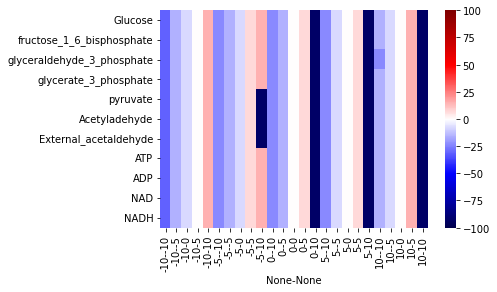

In [16]:
# Presentation of all variables that scales to a large number of interactions
percents = [-10, -5, 0, 5, 10]
fDF, _ = runExperiments2WD("J1_k1", "J1_Ki", percents, percents)
_ = sns.heatmap(fDF.transpose(), cmap='seismic', vmin=-100, vmax=100)

Insights
1. All chemical species have similar trends in osciallation patterns.
1. J1_Ki has more influence on oscillation frequency than J1_k1.
1. Non-monotone effect when J1_Ki is increased in that oscillation frequency increase and then radically fall.

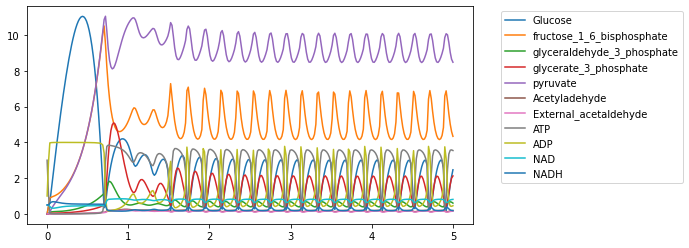

In [17]:
# Baseline
plotOverTime(runSimulation({}))

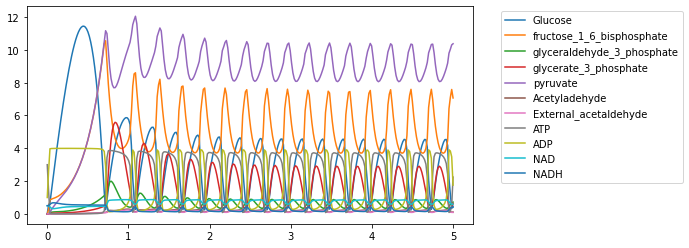

In [18]:
# Decrease J1_Ki
parameterDct = {"J1_Ki": -10}
df = runSimulation(parameterDct)
plotOverTime(df)

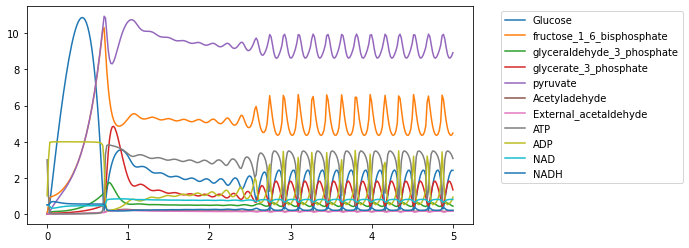

In [19]:
# 5% increase in J1_Ki
parameterDct = {"J1_Ki": 5}
df = runSimulation(parameterDct)
plotOverTime(df)

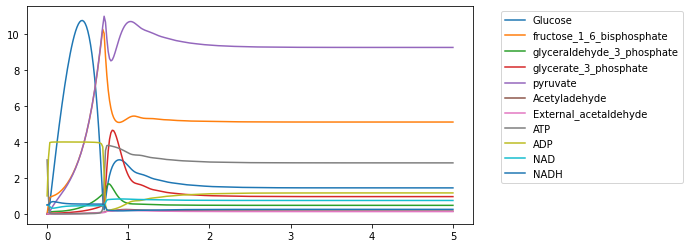

In [20]:
# 10% increase in J1_Ki
parameterDct = {"J1_Ki": 10}
df = runSimulation(parameterDct)
plotOverTime(df)

## Visualizing interactions for a single molecule

The following code makes use of the pandas ``pivot`` function to create a table where rows and columns represent different levels of the two factors.

In [21]:
def pivotResponse(responseDF, molecule):
    """
    Creates a DataFrame in which values of the parameters are rows and columns.
    
    Parameters
    ----------
    responseDF: DataFrame
        columns: molecule names
        rows: tuple of percent changes in parameters
        values: response
        index.name: string of tuple (rowParameter, columnParameter)
    molecule: str
        
    Returns
    -------
    DataFrame
        columns: values of columnParameter
        rows: values of rowParameter
        cells: response for molecule
    """
    LEVEL0 = "level_0"
    LEVEL1 = "level_1"
    df = responseDF.reset_index()
    resultDF = pd.pivot_table(df, values=molecule, index=LEVEL0, columns=LEVEL1)
    parameters = eval(responseDF.index.name)
    resultDF.index.name = parameters[0]
    resultDF.columns.name = parameters[1]
    return resultDF

# Tests
df = pivotResponse(TEST_FDF, "Glucose")
#pd.pivot_table(df, values="Glucose", index="level_0", columns="level_1")
assert(len(df.index) == len(df.columns))

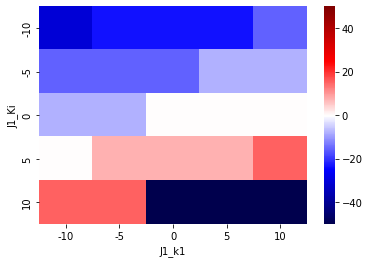

In [22]:
# Visualization that provides more insight
percents = [-10, -5, 0, 5, 10]
fDF, _ = runExperiments2WD("J1_Ki", "J1_k1", percents, percents)
_ = sns.heatmap(pivotResponse(fDF, "Glucose"), cmap='seismic', vmin=-50, vmax=50)

A function that encapsulates the foregoing for the output of 2WD experiments.

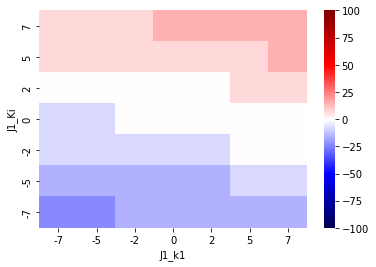

In [23]:
def makeHeatmap(responseDF, molecule, isColorbar=True, ax=None, vmin=-100, vmax=100, cbar_ax=None):
    """
    Creates a heatmap showing the interactions of response values for two parameters.
    
    Parameters
    ----------
    reponseDF: DataFrame
        index: tuples of percent changes in parameter values
        columns: molecule
        values: response
    molecule: str
    isColorbar: bool
        show the colorbar
    vmin: float
        minimum value in color bar
    vmax: float
        maximum value in color bar
    cbar_ax: Axes
    """
    df = pivotResponse(responseDF, molecule)
    df = df.sort_index(ascending=False)  # Show large values on top
    if ax is None:
        ax = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, cbar_ax=cbar_ax)
    else:
        _ = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, ax=ax, cbar_ax=cbar_ax)
    return ax

# Tests
_ = makeHeatmap(TEST_FDF, "ATP")

# Calculating DOE Parameters

For 2WD, we must calculate $\mu, \alpha_{i, k_i}, \alpha_{i, k_i, j, k_j}$.
1. Use 1WD to obtain $\mu, \alpha_{i, k_i}$
1. Calculate $y_{i, k_i, j, k_j}$ responses
1. Calculate $\alpha_{i, k_i, j, k_j}$: $\alpha_{i, k_i, j, k_j} = y_{i, k_i, j, k_j} - \mu
- \alpha_{i, k_i} - \alpha_{j, k_j}$

## Extracting 1WD information from a 2WD experiment

A 2WD experiment contains information from two 1WD experiments.
The function ``calc1WDParameters`` calculates $\mu$, $\alpha_{i, k_i}$, $\alpha_{j, k_j}$.

In [24]:
def calc1WDParameters(response2WDDF):
    """
    Constructs a 1WD response for a single molecule from the results for a 2WD experiment.
    
    Parameters
    ----------
    response2WDDF: DataFrame (Response2WDDF)
    factor: str
    molecule: str
    
    Returns
    -------
    Series: mu
    DataFrame: response for first factor
        index: int (percent change)
        value: float (percent change)
    DataFrame: response for second factor
        index: int (percent change)
        value: float (percent change)  
    """
    def calcFactorSer(pos):
        """
        Calculates the Series for a factor.
        
        Parameters
        ----------
        pos: int
            in the set {0, 1}
          
        Returns
        -------
        DataFrame
        """
        # Find the levels
        levels = list(set([i[pos] for i in response2WDDF.index]))
        levels.sort()
        # Find the indices that determine the 1WD responses
        indices = [(i, 0) for i in levels]
        if pos == 1:
            indices = [(j, i) for i,j in indices]
        #
        df = response2WDDF.loc[indices]
        newIndices = [i[pos] for i in df.index]
        df.index = newIndices
        return df
    # 
    mu = response2WDDF.loc[(0, 0), :]
    alphaiDF = calcFactorSer(0) - mu
    alphajDF = calcFactorSer(1) - mu
    #
    return mu, alphaiDF, alphajDF

# TESTS
muSer, df1, df2 = calc1WDParameters(fDF)
assert(all([m == 0 for m in muSer]))
for df in [df1, df2]:
    assert(isinstance(df, pd.DataFrame))
    assert(len(df) == 5)

## Calculating $\alpha_{i, k_i, j, k_j}$

In [25]:
def calc2WDParameters(response2WDDF):
    """
    Calculates the design of experiment parameters for a 2-Way Design.
    Assumes that there is a level of 0.

    Parameters
    ----------
    DataFrame
       index: tuple of percent changes in factor values
       columns: molecule
       value: float (response)
       index.name: string of tuple (rowFactor, columnFactor)
    
    Returns
    -------
    Series: mu values for factors
    pd.DataFrame: alpha_i,k_i
        column: molecule
        index: factor i levels
        value: float
    pd.DataFrame: alpha_j,k_j
        column: molecule
        index: factor j levels
        value: float
    pd.DataFrame: alpha_i,k_i,j,k_j
        column: molecule
        index: factor i, factor j levels
        value: float
    """
    mu, alphaiDF, alphajDF = calc1WDParameters(response2WDDF)
    alphaijDF = response2WDDF - mu
    # Adjust for alpha_i_ki and alpha_j_kj
    for idx, row in alphaijDF.iterrows():
        iLevel, jLevel = idx
        alphaijDF.loc[idx, :] = alphaijDF.loc[idx, :].values - alphaiDF.loc[iLevel, :].values  \
            - alphajDF.loc[jLevel, :].values
    #
    return mu, alphaiDF, alphajDF, alphaijDF

# TESTS
muSer, alphaiDF, alphajDF, alphaijDF = calc2WDParameters(fDF)
assert(isinstance(muSer, pd.Series))
assert(isinstance(alphaiDF, pd.DataFrame))
assert(isinstance(alphajDF, pd.DataFrame))
assert(isinstance(alphaijDF, pd.DataFrame))
assert(len(alphaijDF) == len(alphaiDF)*len(alphajDF))

# Running a Study

A study for 2WD must considerations *combinations* of changes in levels for two factors.
So, running a study must specify: (a) the list of factors considered for changes in combinations
and (b) the levels of factors.

## Calculating responses for 2WD

In [26]:
def runStudy2WD(factor1, factor2, percents, isRelative=True, isFrequency=True):
    """
    Calculates parameters for a 2WD study.
    
    Parameters
    ----------
    molecule: str
    factor1: str
    factor2: str
    percents: list-int
    isRelative: bool
       Results are percent change w.r.t. base
    isFrequency: bool
       Results are for frequencies
       
    Returns
    -------
    Series: mean values
    pd.DataFrame: alpha_i,k_i (response2WDDF)
    pd.DataFrame: alpha_j,k_j (response2WDDF)
    pd.DataFrame: alpha_i,k_i,j,k_j (response2WDDF)
    """
    # Get the 2WD parameters
    frequencyDF, amplitudeDF = runExperiments2WD(factor1, factor2, percents, percents,
                                                 isRelative=isRelative)
    if isFrequency:
        responseDF = frequencyDF
    else:
        responseDF = amplitudeDF
    #
    return calc2WDParameters(responseDF)

# TESTS
muSer, alphaiDF, alphajDF, alphaijDF = runStudy2WD(WOLF_PRMS[1], "J9_k", [-10, -7, -5, 0, 5, 7, 10],
                                                   isFrequency=True)
assert(isinstance(muSer, pd.Series))
for df in [alphaiDF, alphajDF, alphaijDF]:
    assert(len(df) > 0)
    assert(isinstance(df, pd.DataFrame))

In [27]:
alphaijDF

Glucose  fructose_1_6_bisphosphate  ...           NAD          NADH
-10 -10  7.692308e+01              -1.776357e-14  ... -1.776357e-14 -1.776357e-14
    -7  -1.776357e-14              -1.776357e-14  ... -1.776357e-14 -1.776357e-14
    -5   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
     0   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     5  -1.776357e-14              -1.776357e-14  ... -1.776357e-14 -1.776357e-14
     7  -1.776357e-15              -1.776357e-15  ... -1.776357e-15 -1.776357e-15
     10 -1.776357e-15              -1.776357e-15  ... -1.776357e-15 -1.776357e-15
-7  -10  7.692308e+01              -1.776357e-14  ... -1.776357e-14 -1.776357e-14
    -7  -1.776357e-14              -1.776357e-14  ... -1.776357e-14 -1.776357e-14
    -5   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
     0   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     5  -1.776357e-14              -1.776357e-14  ... -1.776357e-14 -1.776357e-14
     7  -1.776357e-15              -1.776357e-15  ... -1.776357e-15 -1.776357e-15
     10  7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
-5  -10  8.461538e+01               7.692308e+00  ...  7.692308e+00  7.692308e+00
    -7   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
    -5   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
     0   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     5   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
     7  -1.776357e-15              -1.776357e-15  ... -1.776357e-15 -1.776357e-15
     10  7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
 0  -10  0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
    -7   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
    -5   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     0   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     5   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     7   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     10  0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
 5  -10  0.000000e+00              -7.692308e+01  ... -7.692308e+01 -7.692308e+01
    -7   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
    -5   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
     0   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     5   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     7   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     10  7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
 7  -10  0.000000e+00              -7.692308e+01  ... -7.692308e+01 -7.692308e+01
    -7   7.692308e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
    -5   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
     0   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     5   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
     7   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     10  7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
 10 -10  0.000000e+00              -7.692308e+01  ... -7.692308e+01 -7.692308e+01
    -7   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
    -5   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
     0   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e+00
     5   7.692308e+00               7.692308e+00  ...  7.692308e+00  7.692308e+00
     7   0.000000e+00               0.000000e+00  ...  0.000000e+00  0.000000e

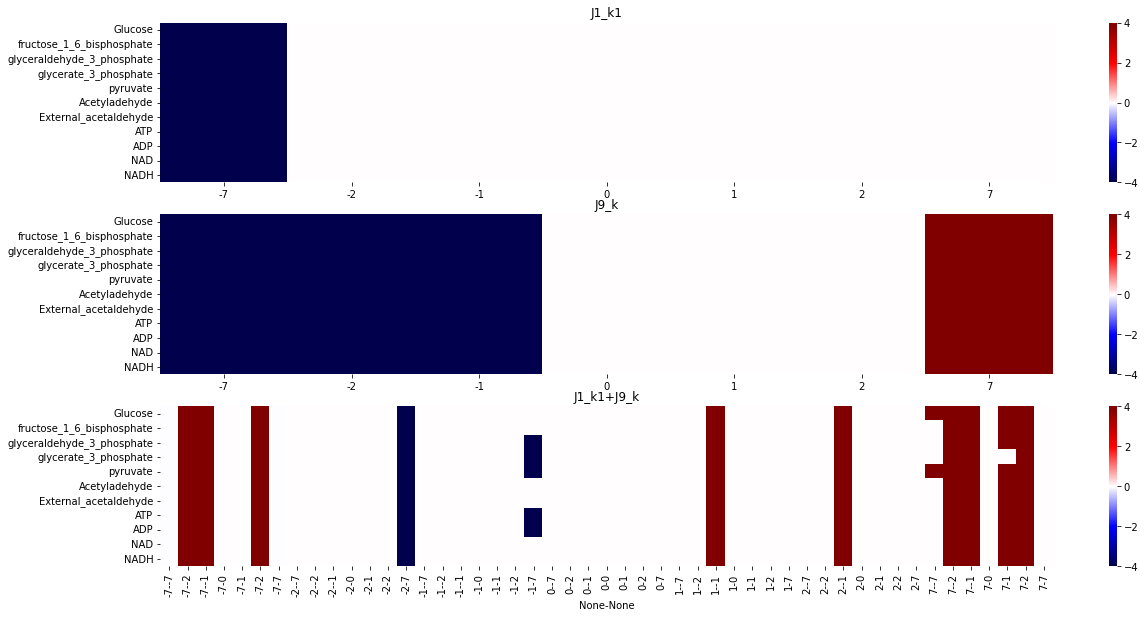

In [28]:
def plot2WD(factor1, factor2, percents, isRelative=True, 
                isFrequency=True, figsize=(20, 10)):
    """
    Plots the alpha for 1WD and 2WD.
    
    Parameters
    ----------
    molecule: str
    factor1: str
    factor2: str
    percents: list-int
    isRelative: bool
       Results are percent change w.r.t. base
    isFrequency: bool
       Results are for frequencies
    figisze: tuple-int
       Size of figures
    """
    def plotParameters(df, ax, factor):
        sns.heatmap(df.T, cmap='seismic', vmin=vmin, vmax=vmax, ax=ax)
        ax.set_title(factor)
    #
    vmin = -4
    vmax = 4
    # Get the 2WD parameters
    mu, alphaiDF, alphajDF, alphaijDF = runStudy2WD(factor1, factor2, percents, isRelative=isRelative,
                                          isFrequency=isFrequency)
    fig, axes = plt.subplots(3, figsize=figsize)
    plotParameters(alphaiDF, axes[0], factor1)
    plotParameters(alphajDF, axes[1], factor2)
    plotParameters(alphaijDF, axes[2], factor1 + "+" + factor2)
    
    
# TESTS
plot2WD("J1_k1", "J9_k", [-7, -2, -1, 0, 1, 2, 7])
    